# (Optional) Load Data from Kaggle into Google Colab

In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'aiim-emotion-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77823%2F8553100%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240626%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240626T115714Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7e88867fb84699bc97bce6b967c9c94a55858f28e62a9666a2a853ba919305523ea7050f1b42f950200efcde3de81036e6b157e24e8e29951a51112d40f1dce8636ed5c493b7af49bb3aff7c1ae7925ca67e809ea683cc2faf136ae513602c156282af29545cb6175b077b53d2ad98f722370df51d73fd59770ddd7dc8a46f5600a04ade8b7c1fabf9a081721877052dee33d24d01b58f2cd0491d3192371c6a0aae56f6c94211f586fb0728ed711bd401a2f4585e18f266cf83dd5547b6aeaf4e2b07e173f143853dfdd0c6cf13656fd3dfdb9ca6257750a62e00a72aa849aaf7c6c9662822065fbeea459e7f15ae2f076547dc851738d0acbc31434afe77e6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 18175099 bytes downloaded
Downloaded and uncompressed: aiim-emotion-classification
Data source import complete.


# Visualizing some images

Classes: {'angry', 'sad', 'fear', 'surprise', 'happy'}
Number of images per class in dataset: {'sad': 2000, 'happy': 2000, 'angry': 2000, 'fear': 1108, 'surprise': 2000}
Different image sizes in dataset with counts: {TensorShape([48, 48, 1]): 7029, TensorShape([128, 128, 1]): 570, TensorShape([100, 100, 1]): 1454, TensorShape([256, 256, 1]): 55}


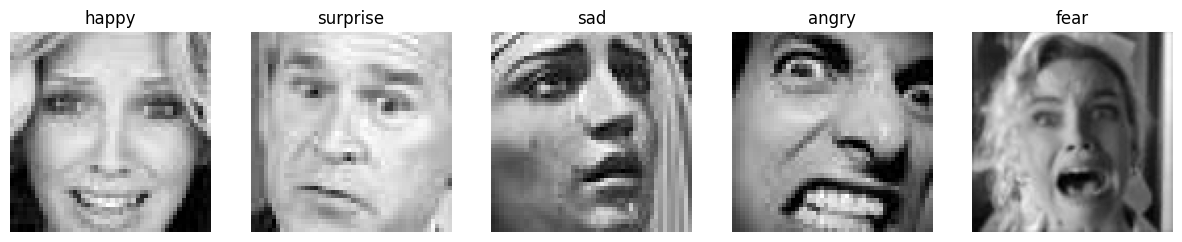

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random

base_directory = '/kaggle/input/aiim-emotion-classification/aiim-emotion-classification/'

def load_images_from_directory(directory):
    image_paths = list(Path(directory).glob('**/*.*'))  # assuming images are in various formats
    images = []
    labels = []
    for image_path in image_paths:
        image = tf.io.read_file(str(image_path))
        image = tf.image.decode_image(image, channels=1)
        images.append(image)
        label = image_path.parent.name
        labels.append(label)
    return images, labels

def get_image_sizes_with_counts(images):
    size_counts = {}
    for image in images:
        size = image.shape
        if size not in size_counts:
            size_counts[size] = 0
        size_counts[size] += 1
    return size_counts

def count_images_per_class(labels):
    class_counts = {}
    for label in labels:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1
    return class_counts

def plot_images(images, titles, rows=1, cols=5, figsize=(15, 5)):
    plt.figure(figsize=figsize)
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(tf.squeeze(images[i]), cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

def shuffle_images_and_labels(images, labels):
    combined = list(zip(images, labels))
    random.shuffle(combined)
    images[:], labels[:] = zip(*combined)
    return images, labels

def get_one_image_per_class(images, labels):
    class_image_dict = {}
    for image, label in zip(images, labels):
        if label not in class_image_dict:
            class_image_dict[label] = image
    return class_image_dict

train_directory = os.path.join(base_directory, 'train/')
images, labels = load_images_from_directory(train_directory)

# Namen der Klassen
class_names = set(labels)
print("Classes:", class_names)

# Anzahl der Bilder pro Klasse
class_counts = count_images_per_class(labels)
print("Number of images per class in dataset:", class_counts)

# Verschiedene Bildgrößen und deren Anzahl
image_sizes_with_counts = get_image_sizes_with_counts(images)
print("Different image sizes in dataset with counts:", image_sizes_with_counts)

# Mischen der Bilder und Labels
images, labels = shuffle_images_and_labels(images, labels)

# Ein Bild pro Klasse abrufen
class_image_dict = get_one_image_per_class(images, labels)
images_to_plot = list(class_image_dict.values())
titles_to_plot = list(class_image_dict.keys())

# Bilder plotten
plot_images(images_to_plot, titles=titles_to_plot, rows=1, cols=len(images_to_plot))
